In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

INPUT = '/scratch/users/k21075402/new/commons_harvest__open/'
TRIAL_IDS_SP = ['39596646', '3f82a7f6', 'b484e613', 'd1a59a0e', 'ebcd23ed']
TRIAL_IDS_ID = ['41697eb3', '68238f61', 'b0569bd9', 'd1ec3174', 'eb100aee']

window = 21
epochs = 300

In [2]:
def load_df(trial_id: str, *, independent: bool=False, num_players: int=None, self_interest: float=None):
    df = pd.read_json(os.path.join(INPUT, trial_id, 'results.json'), lines=True)
    df['reward'] = df.episode_reward.apply(lambda x: np.mean(x))
    df['trial_id'] = trial_id
    assert num_players is None or self_interest is None, 'Can only select based on either num_players or self_interest'
    # df = df[(df['num_players'] == num_players) & (df['self-interest'] == self_interest)]
    if num_players is not None:
        df = df[(df['num_players'] == num_players)]
        df = df.sort_values(by=['self-interest', 'training_iteration'], ascending=[False, True])
        df = df.reset_index(drop=True)
        df['iteration'] = df.index + 1
    elif self_interest is not None:
        df = df[(df['self-interest'] == self_interest)]
        df['iteration'] = df.training_iteration + 300 * (df.num_players - 1)
    
    df = df.drop(columns=['training_iteration', 'episode_reward', 'episode_lengths'])
    if independent:
        df = df.drop(columns=df.filter(regex='policy_player_').columns)
    else:
        df = df.drop(columns=['policy_default_reward'])
    return df

In [3]:
def plot_num_players(df, rolling: bool = False):
    grouped = df.groupby('trial_id')

    # Plot each group
    fig, ax = plt.subplots(figsize=(12, 5), facecolor='white')
    for name, group in grouped:
        if rolling:
            result = group['reward'].rolling(window=window, center=True).mean()
            indices = [list(range(epochs*i - window//2 + 1, epochs*i + window//2 +1)) for i in range(1, 7)]
            result.iloc[indices] = np.nan
            result.plot(ax=ax, label=name, legend=False, lw=0.75)
        else:
            group.plot(x='iteration', y='reward', ax=ax, label=name, legend=False, lw=0.75)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Social welfare')
    ax.set_xlim(0, 2100)
    ax.set_ylim(0, 900)
    ax.set_xticks(np.arange(0, 2101, 300))
    ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='grey', alpha=0.5)
    ax.xaxis.grid(True, color='grey', linestyle='--', alpha=0.5)
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())  # Make sure the limits are the same
    ax2.set_yticks(ax.get_yticks())  # Duplicate the tick marks
    
    regions = dict((str(i), i * 300) for i in range(1,8))
    
    for region, position in regions.items():
        # ax.axvline(x=position, color='gray', linestyle='--', alpha=0.5)
        ax.text(position-150, 1.02, region, transform=ax.get_xaxis_transform(), horizontalalignment='center')

    return fig, ax

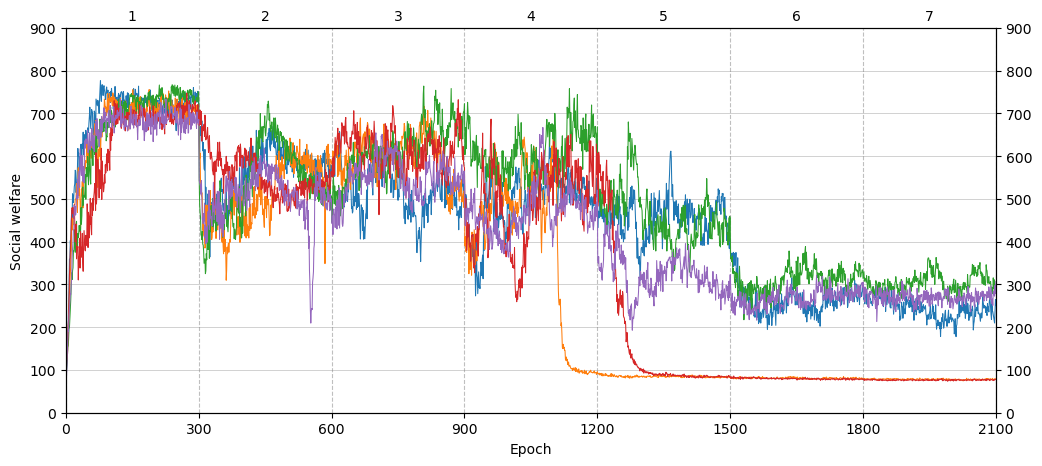

In [4]:
df = pd.concat([load_df(t, self_interest=1) for t in TRIAL_IDS_SP])

fig, ax = plot_num_players(df)

fig.savefig('num_players_self_play')

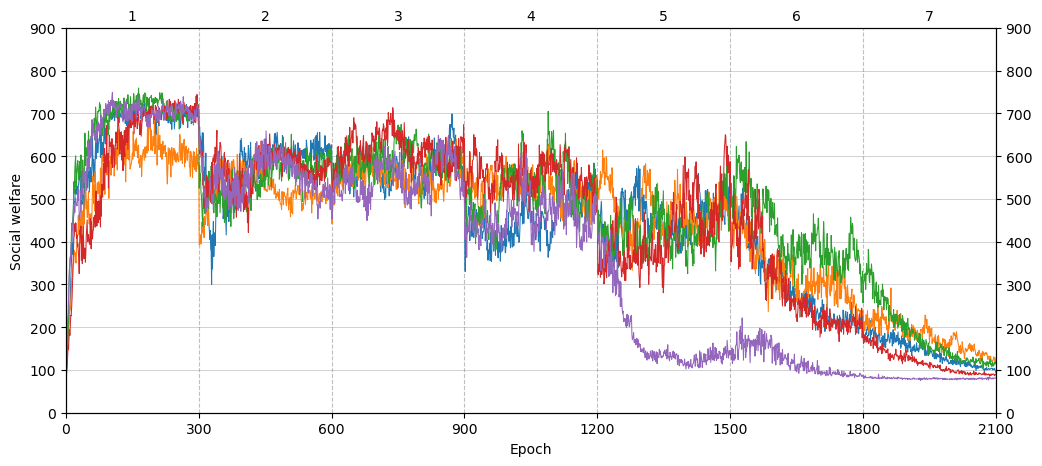

In [5]:
df = pd.concat([load_df(t, independent=True, self_interest=1) for t in TRIAL_IDS_ID])

fig, ax = plot_num_players(df)

fig.savefig('num_players_independent')

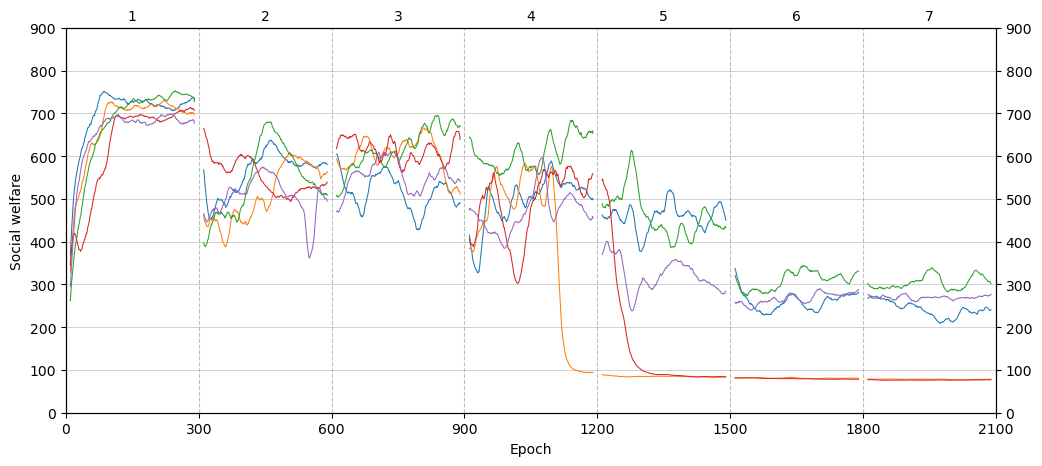

In [6]:
df = pd.concat([load_df(t, self_interest=1) for t in TRIAL_IDS_SP])

fig, ax = plot_num_players(df, True)

fig.savefig('num_players_self_play_rolling')

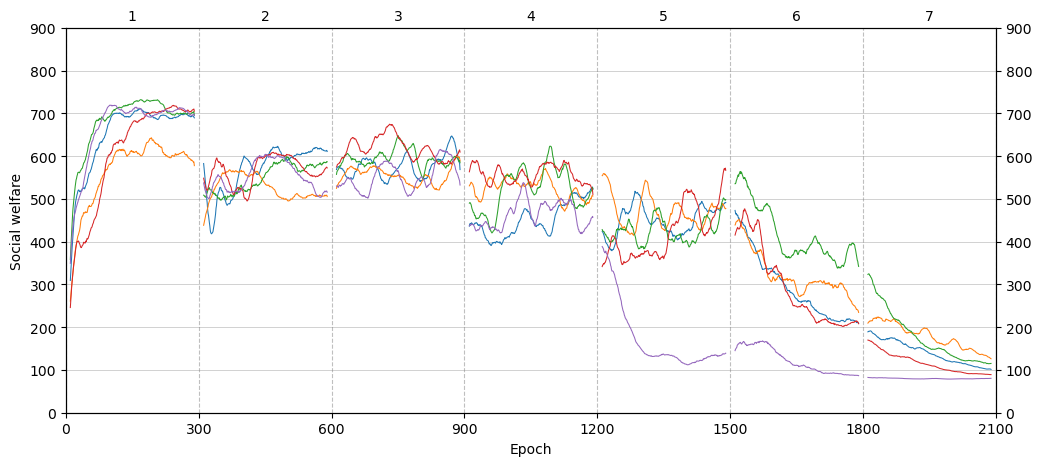

In [7]:
df = pd.concat([load_df(t, independent=True, self_interest=1) for t in TRIAL_IDS_ID])

fig, ax = plot_num_players(df, True)

fig.savefig('num_players_independent_rolling')

In [9]:
def plot_self_interest(df, rolling: bool = False):
    grouped = df.groupby('trial_id')

    fig, ax = plt.subplots(figsize=(12, 5), facecolor='white')
    for name, group in grouped:
        if rolling:
            result = group['reward'].rolling(window=window, center=True).mean()
            indices = [list(range(epochs*i - window//2 + 1, epochs*i + window//2 +1)) for i in range(1, 10)]
            result.iloc[indices] = np.nan
            result.plot(ax=ax, label=name, legend=False, lw=0.75)
        else:
            group.plot(x='iteration', y='reward', ax=ax, label=name, legend=False, lw=0.75)
        
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Social welfare')
    ax.set_title(f'{n} players', y=1.05)
    ax.set_xlim(0, 3000)
    ax.set_ylim(0, 900)
    ax.set_xticks(np.arange(0, 3001, 300))
    ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='grey', alpha=0.5)
    ax.xaxis.grid(True, color='grey', linestyle='--', alpha=0.5)
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    
    ratio = [20, 10, 5, 3, 5/2, 2, 5/3, 4/3, 1]
    regions = dict((f"{s:.2f}", (1+i) * 300) for i, s in enumerate([1] + [r/(n + r - 1) for r in ratio]))
    
    for region, position in regions.items():
        ax.text(position-150, 1.02, region, transform=ax.get_xaxis_transform(), horizontalalignment='center')

    return fig, ax


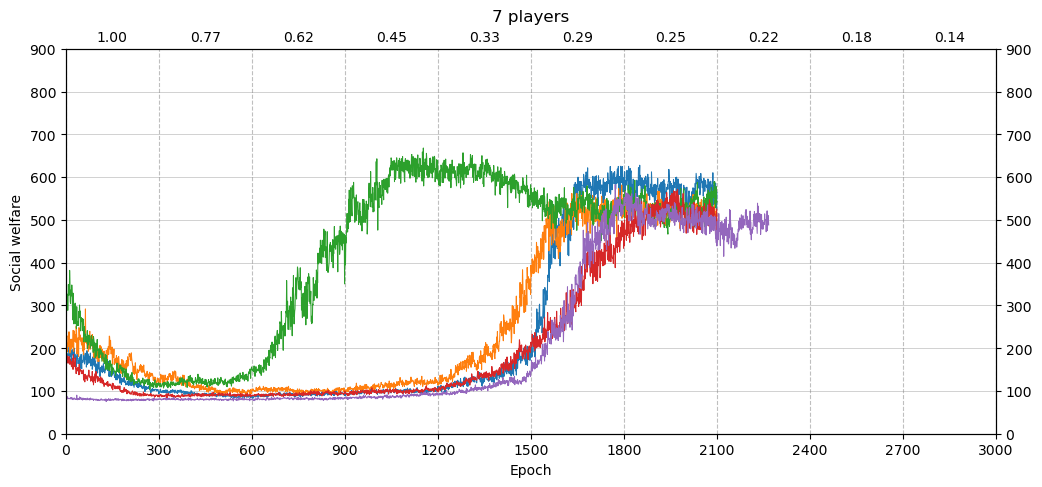

In [12]:
n = 7
independent = True

tids = TRIAL_IDS_ID if independent else TRIAL_IDS_SP
df = pd.concat([load_df(t, independent=independent, num_players=n) for t in tids])

fig, ax = plot_self_interest(df)

name = 'independent' if independent else 'self_play'
fig.savefig(f'self_interest_{name}_{n}')

IndexError: index 2100 is out of bounds for axis 0 with size 2100

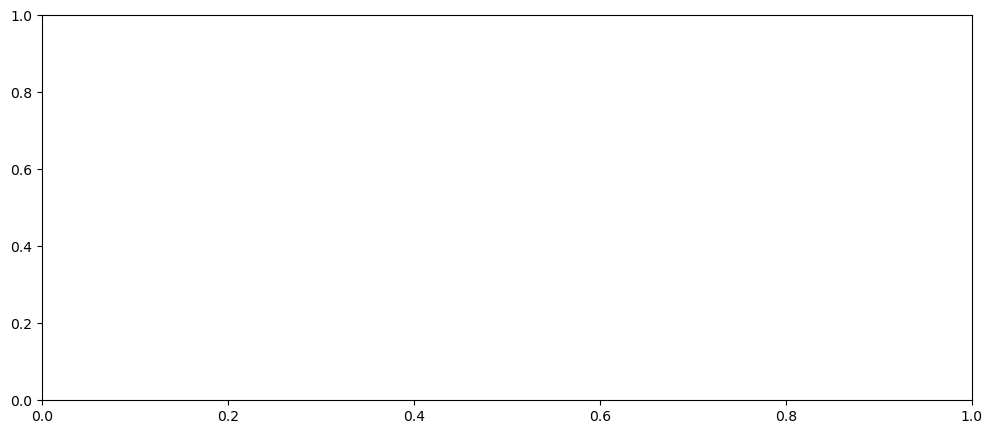

In [13]:
fig, ax = plot_self_interest(df, True)

fig.savefig(f'self_interest_{name}_{n}_rolling')

In [11]:
df

,self-interest,num_players,policy_default_reward,reward,trial_id,iteration
0,1.0,7,"[43.0, 54.0, 24.0, 27.0, 26.0, 26.0, 22.0, 53....",283.266667,39596646,1
1,1.0,7,"[69.0, 50.0, 42.0, 38.0, 43.0, 44.0, 38.0, 44....",264.700000,39596646,2
2,1.0,7,"[67.0, 58.0, 50.0, 33.0, 44.0, 53.0, 56.0, 43....",271.133333,39596646,3
3,1.0,7,"[37.0, 30.0, 25.0, 31.0, 22.0, 22.0, 23.0, 37....",254.366667,39596646,4
4,1.0,7,"[45.0, 57.0, 30.0, 51.0, 32.0, 35.0, 24.0, 52....",268.266667,39596646,5
...,...,...,...,...,...,...
295,1.0,7,"[51.0, 54.0, 45.0, 46.0, 62.0, 40.0, 54.0, 32....",275.266667,ebcd23ed,296
296,1.0,7,"[57.0, 62.0, 47.0, 34.0, 41.0, 52.0, 57.0, 54....",272.533333,ebcd23ed,297
297,1.0,7,"[60.0, 48.0, 41.0, 56.0, 44.0, 66.0, 39.0, 51....",297.766667,ebcd23ed,298
298,1.0,7,"[46.0, 29.0, 25.0, 28.0, 27.0, 31.0, 42.0, 42....",278.300000,ebcd23ed,299
